# CART and Random Forests for CA Housing data Regression 



"California Housing" is a famous data set containing over 20,000 data on houeses in California with several features such as location (given by longitude and lattitude information,) number of bedrooms, population in the district the house is located, average household income in that region, and many other features. This dataset is directly availble in ``scikit-learn`` datasets. The target variable is the ``MedHouseVal``.

We are going to apply CART, Bagging and Random Forest methods on this dataset and build and analyze several regression models based on trees. This dataset has been thoroughly analyzed in Chapter 2 of the "Handbook". I strongly recommend you read that chapter along with studying this notebook.

First let us read and process the data:

In [1]:
from sklearn.datasets import fetch_california_housing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pandas.plotting import scatter_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
#from sklearn.impute import SimpleImputer #not needed here
from sklearn.metrics import mean_squared_error, r2_score


dat=fetch_california_housing()
Xlabel,ylabel=dat['feature_names'],dat['target_names']

#X,y=dat['data'],dat['target']
housingDf=pd.DataFrame(np.append(dat['data'],dat['target'].reshape((len(dat['target']),1)),axis=1),\
                                  columns=dat['feature_names']+dat['target_names'])
display(housingDf)
# To get mre information about this dagtaset uncomment the line below and read the output:
#print(dat.DESCR'])

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422
...,...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,0.781
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21,0.771
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,0.923
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,0.847


## Visualizing Some aspects of the Data

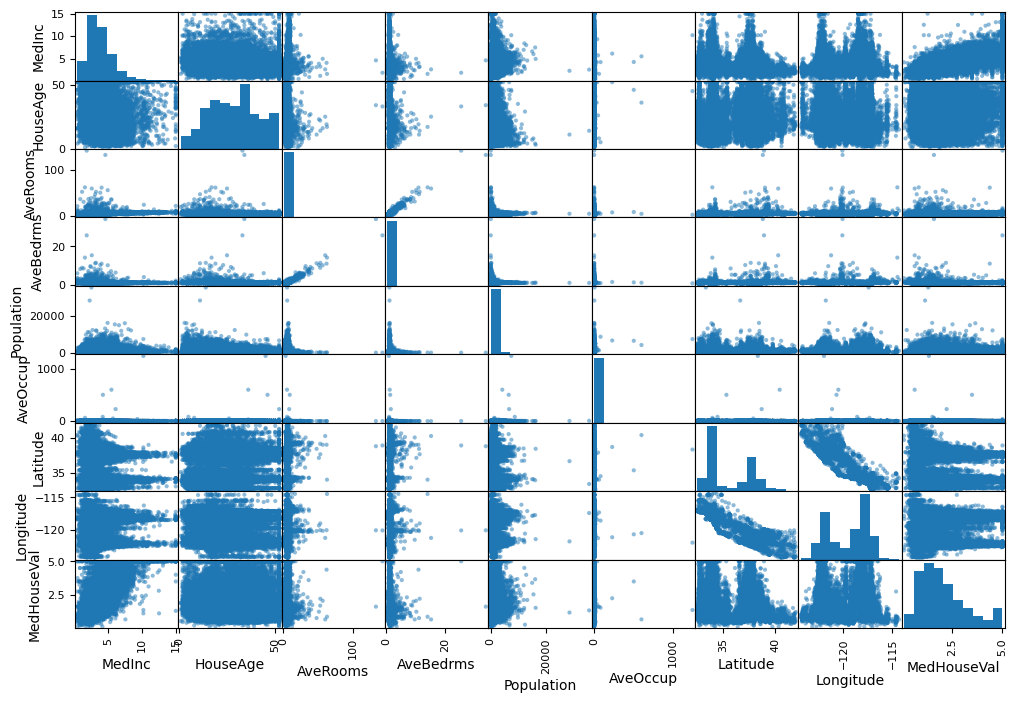

In [15]:
_=scatter_matrix(housingDf,figsize=(12,8))

##  Visualizing the location, density and relation to income and housevalu using colors

<Axes: xlabel='Longitude', ylabel='Latitude'>

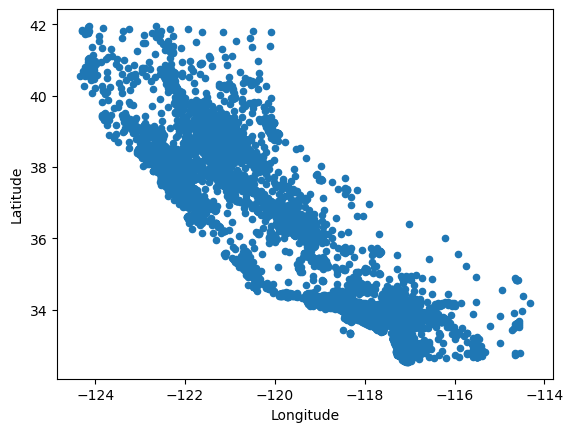

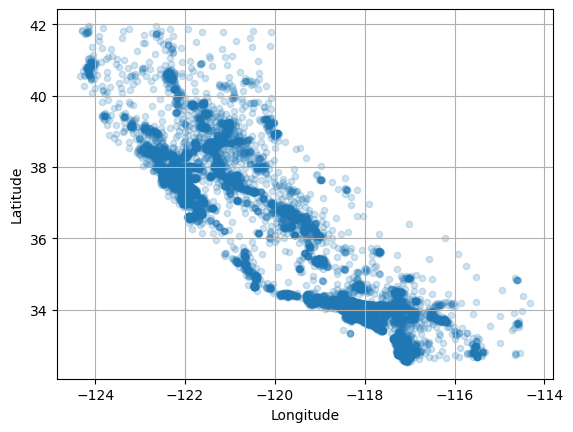

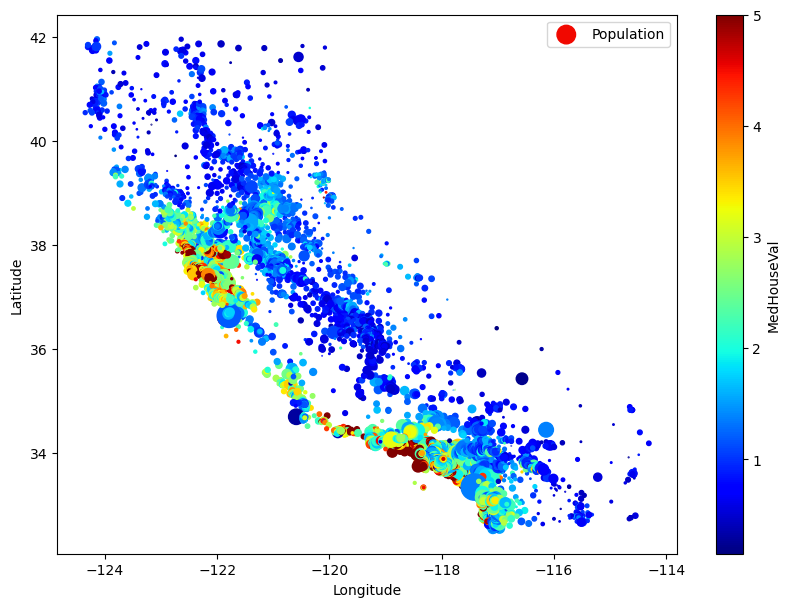

In [3]:
housingDf.plot(kind='scatter', x='Longitude', y='Latitude')

housingDf.plot(kind='scatter', x='Longitude', y='Latitude', grid=True, alpha=0.2)

housingDf.plot(kind='scatter', x='Longitude', y='Latitude',
              s=housingDf['Population']/100, label="Population",
              c='MedHouseVal', cmap="jet", colorbar=True,
              legend=True, sharex=False, figsize=(10,7))

## Prepare the data by splitting into training and test sets

In [4]:
p=0.2
X_train,X_test,y_train,y_test=train_test_split(housingDf[housingDf.columns[:-1]],\
                                        housingDf[housingDf.columns[-1]],test_size=p,\
                                        random_state=10) # To get reproducuible results, not necessary
#housingDfSmall=housingDf.sample(n=5000,axis='index')


## California Housing Regression witth CART and Cost-Complexity Pruning

In the following cell we implement "by hand" the cost complexity pruning:

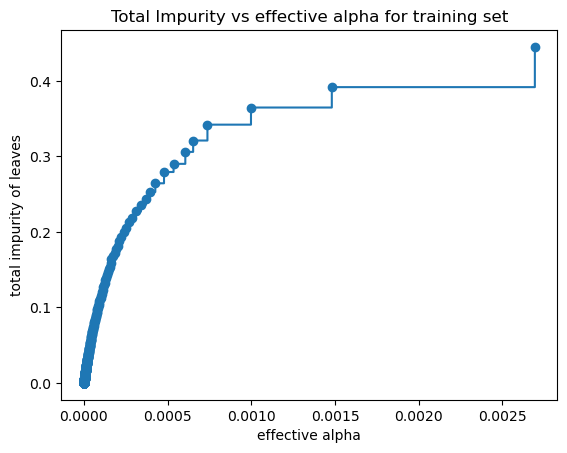

In [5]:
from sklearn.tree import DecisionTreeRegressor, plot_tree, export_text

tree=DecisionTreeRegressor(random_state=0)
path = tree.cost_complexity_pruning_path(X_train, y_train)
alphas1, impurities1 = path.ccp_alphas, path.impurities

hop=20 # pick only every 'hop' of the alphsas:
alphas=np.array([alphas1[i] for i in range(0,alphas1.shape[0], hop)])
impurities=np.array([impurities1[i] for i in range(0,impurities1.shape[0], hop)])

#

fig, ax = plt.subplots()
ax.plot(alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")
plt.show()

In [9]:
alphas1.shape, alphas.shape, alpha

((14852,), (743,), 0.0)

Now build tree models for each alpha:

In [10]:
treeList = []
for a in alphas:
    tree = DecisionTreeRegressor(random_state=0, ccp_alpha=a)
    tree.fit(X_train, y_train)
    treeList.append(tree)

bestScore, bestTreeModel,optAlpha = -np.inf, None,0
train_scores,test_scores = [],[]
depth,node_counts = [],[]

#for i in range(0,alphas.shape[0]):
for alpha in alphas:
    tree =  DecisionTreeRegressor(random_state=0, ccp_alpha=alpha)
    tree.fit(X_train, y_train)
    train_score = tree.score(X_train, y_train)
    test_score = tree.score(X_test, y_test)
    train_scores,test_scores = train_scores+[train_score], test_scores+[test_score]
    depth,node_counts=depth+[tree.get_depth()],node_counts+[tree.tree_.node_count]
    if test_score>bestScore: 
        bestScore=test_score
        bestTreeModel=tree
        optAlpha=alpha


print(f"Number of nodes in the last tree is: {treeList[-1].tree_.node_count} with ccp_alpha: {alphas[-1]}")

#input('Hit enter')
treeList = treeList[:-1]
alphas = alphas[:-1]

node_counts = [tree.tree_.node_count for tree in treeList]
depth = [tree.tree_.max_depth for tree in treeList]

Number of nodes in the last tree is: 23 with ccp_alpha: 0.009052520658193286


Plot node counts and depth as a function of $\alpha$'s

In [11]:
len(node_counts)

742

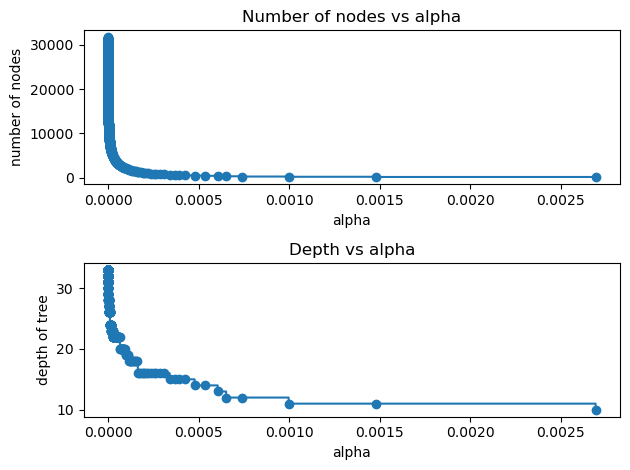

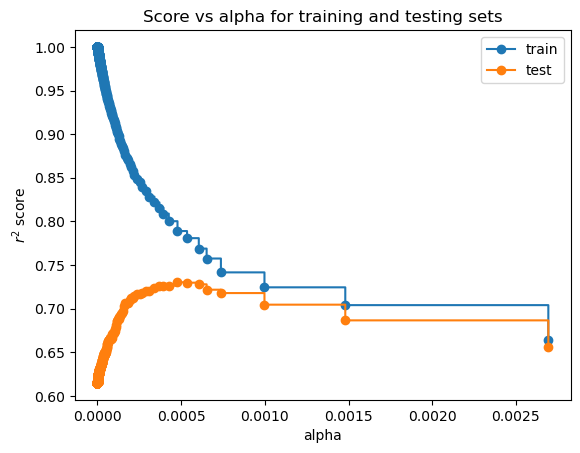

bestTreeodel score R^2: 0.730, achieved at alpha= 0.0004783015284033354


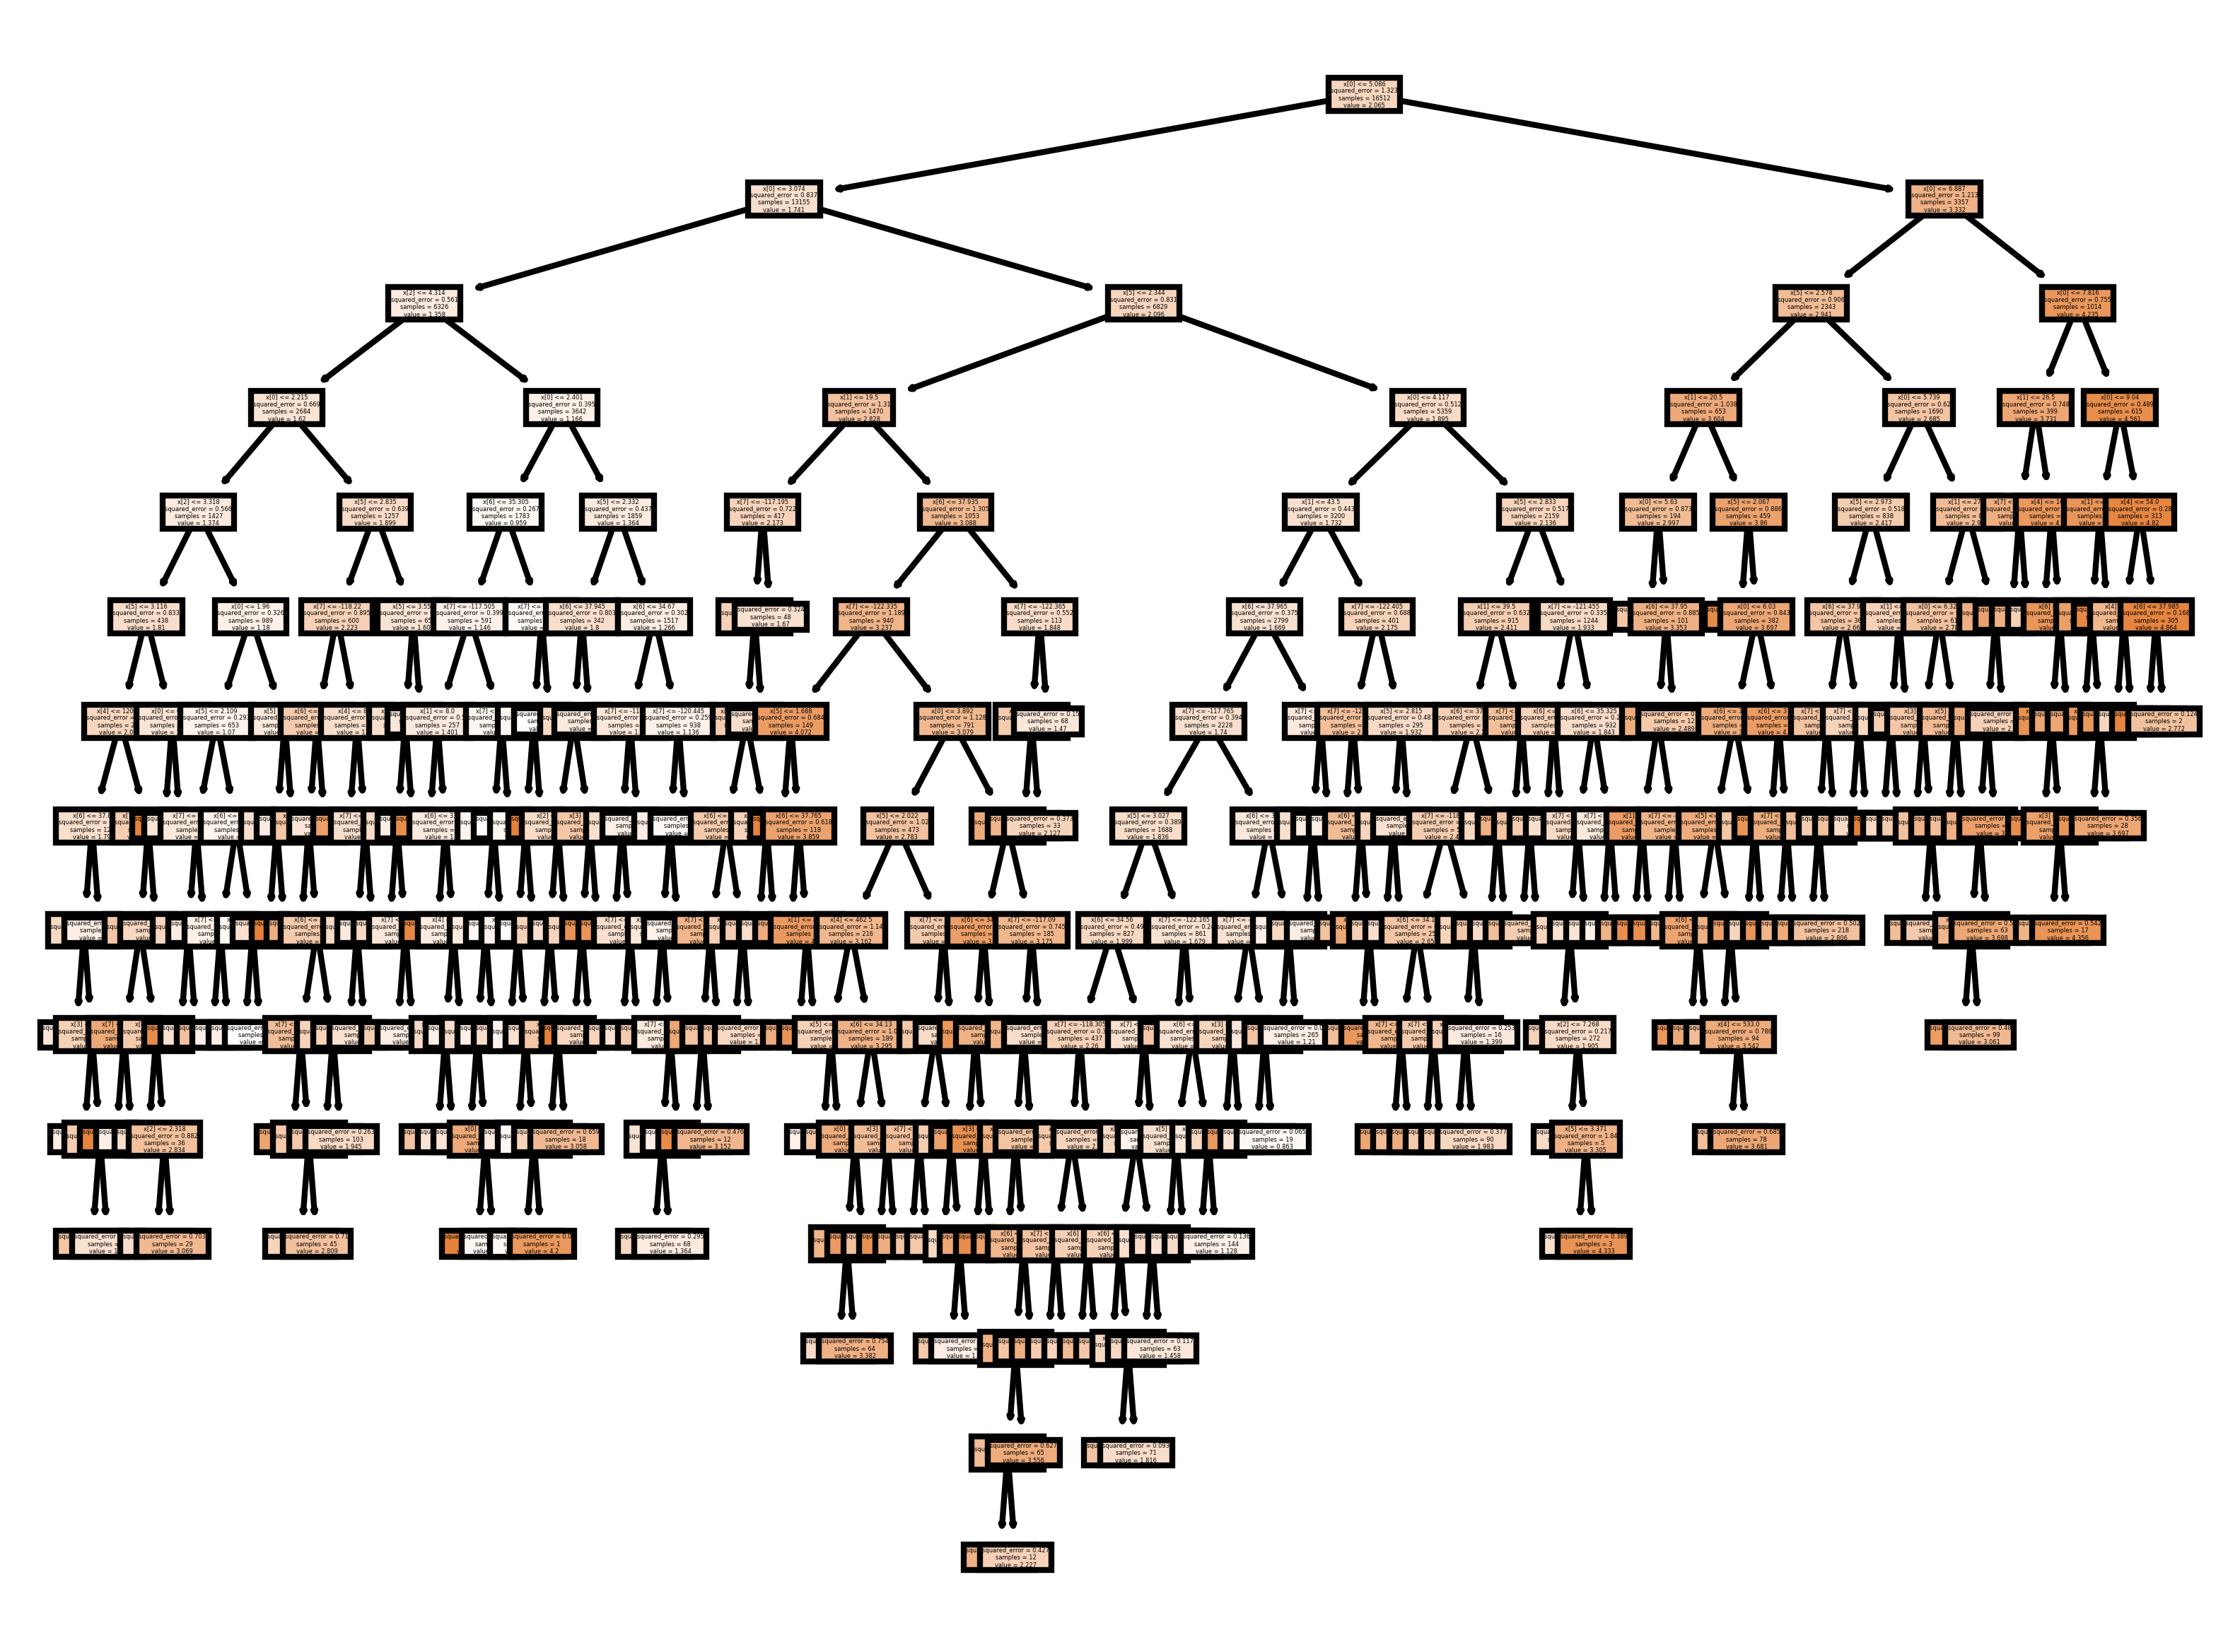

|--- feature_0 <= 5.09
|   |--- feature_0 <= 3.07
|   |   |--- feature_2 <= 4.31
|   |   |   |--- feature_0 <= 2.21
|   |   |   |   |--- feature_2 <= 3.32
|   |   |   |   |   |--- feature_5 <= 3.12
|   |   |   |   |   |   |--- feature_4 <= 1209.50
|   |   |   |   |   |   |   |--- feature_6 <= 37.80
|   |   |   |   |   |   |   |   |--- feature_6 <= 34.01
|   |   |   |   |   |   |   |   |   |--- value: [1.53]
|   |   |   |   |   |   |   |   |--- feature_6 >  34.01
|   |   |   |   |   |   |   |   |   |--- feature_3 <= 0.94
|   |   |   |   |   |   |   |   |   |   |--- value: [1.24]
|   |   |   |   |   |   |   |   |   |--- feature_3 >  0.94
|   |   |   |   |   |   |   |   |   |   |--- feature_3 <= 1.12
|   |   |   |   |   |   |   |   |   |   |   |--- value: [2.66]
|   |   |   |   |   |   |   |   |   |   |--- feature_3 >  1.12
|   |   |   |   |   |   |   |   |   |   |   |--- value: [1.68]
|   |   |   |   |   |   |   |--- feature_6 >  37.80
|   |   |   |   |   |   |   |   |--- value: [1.22]
|

In [12]:
fig, ax = plt.subplots(2, 1)
ax[0].plot(alphas, node_counts, marker='o', drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(alphas, depth, marker='o', drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

train_scores = [tree.score(X_train, y_train) for tree in treeList]
test_scores = [tree.score(X_test, y_test) for tree in treeList]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel(f"$r^2$ score")
ax.set_title("Score vs alpha for training and testing sets")
ax.plot(alphas, train_scores, marker='o', label="train",
        drawstyle="steps-post")
ax.plot(alphas, test_scores, marker='o', label="test",
        drawstyle="steps-post")
ax.legend()
plt.show()


#bestTreeModel=treeList[np.argmax(test_scores)]
bestTreeModel.predict(X_test)
y_pred=bestTreeModel.predict(X_test)
print(f"bestTreeodel score R^2: {bestTreeModel.score(X_test,y_test):5.3f}, achieved at alpha= {alphas[np.argmax(test_scores)]}")

#input("Hit Enter to see the tree and some of its characteristics")
fig=plt.figure(dpi=600)
sub=fig.add_subplot(1,1,1)
plot_tree(bestTreeModel,filled=True)
plt.show()
print(export_text(bestTreeModel))
print(f"Maximum Depth of the the tree is {bestTreeModel.tree_.max_depth}")
print(f"Number of nodes of the tree is {bestTreeModel.tree_.node_count}")
print(f"Number of leaves (AKA number of regions) is {bestTreeModel.tree_.n_leaves}")

In [13]:
print(max(train_scores), np.argmax(train_scores), max(test_scores), np.argmax(test_scores))
print(path.ccp_alphas.shape, path.impurities.shape,alphas.shape, len(node_counts))
print(f"Best tree with alpha={alphas[np.argmax(test_scores)]:5.3f} has R^2={bestScore:5.3}")
print(X_train.shape[0], alphas.shape[0])


1.0 0 0.7302015409210587 734
(14852,) (14852,) (742,) 742
Best tree with alpha=0.000 has R^2= 0.73
16512 742


# California Housing Regression with Random Forests

In [14]:
from sklearn.ensemble import RandomForestRegressor

forestRegressor=RandomForestRegressor(n_estimators=500, min_samples_leaf=10, oob_score=True)
forestRegressor.fit(X_train,y_train)
y_pred=forestRegressor.predict(X_test)
y_pred_train=forestRegressor.predict(X_train)
print(f"The test mean squarre error for random forest {mean_squared_error(y_test,y_pred):5.3f}")
print(f"The test r2 for random forest: {r2_score(y_test,y_pred):5.3f}")
print(f"The train mean score error for random forest: {mean_squared_error(y_train,y_pred_train):5.3f}")
print(f"The train r2 for random forest: {r2_score(y_train,y_pred_train):5.3f}")
print(f"The out-of-bag score is: {forestRegressor.oob_score_:5.3f}")



The test mean squarre error for random forest 0.277
The test r2 for random forest: 0.797
The train mean score error for random forest: 0.172
The train r2 for random forest: 0.870
The out-of-bag score is: 0.797


In [ ]:
plt.barh((X_train.columns), forestRegressor.feature_importances_,align='center')
plt.yticks(np.arange(len(X_train.columns)),X_train.columns,fontsize=5)
plt.title("Importance of features in the the random forest")
plt.show()